In [29]:
# !pip install matplotlib
# !pip install scikit-learn
# !pip install tensorflow
# !pip install pandas
# !pip install torch
# !pip install tensorflow_probability
# !pip install tqdm
# !pip install tf_keras
# !pip install tqdm

In [30]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.datasets import fetch_openml

In [31]:
data = fetch_openml(name="boston", version=1, as_frame=False)
X, y = data.data.astype(float), data.target

x_train, x_test = torch.from_numpy(X[:350,:]).float(), torch.from_numpy(X[350:,:]).float()
y_train, y_test = torch.from_numpy(y[:350]).float(), torch.from_numpy(y[350:]).float()

X.shape

(506, 13)

In [35]:
class MeanFieldLayer(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=1e-3):
        super(MeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.zeros(input_dim, output_dim)
        self.b_mu_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.zeros(output_dim)

        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Normal(self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Normal(self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.Normal(self.w_mu_q, (0.5 * self.w_log_var_q).exp())

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.Normal(self.b_mu_q, (0.5 * self.b_log_var_q).exp())

    def kl(self):
        weight_kl = torch.distributions.kl.kl_divergence(self.q_w(), self.p_w()).sum() 
        bias_kl = torch.distributions.kl.kl_divergence(self.q_b(), self.p_b()).sum()
        return weight_kl + bias_kl

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        return x @ weights + biases # (num_samples, batch_size, output_dim).



class MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation=nn.LeakyReLU(negative_slope=0.1),
        noise_std=1.0,
    ):
        super(MeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.noise_covar = torch.eye(output_dim)*noise_std

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer(self.input_dim, self.hidden_dims[i]))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.output_dim)
                )
            else:
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i])
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)

        # Propagate x through network
        for layer in self.network:
            x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x

    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""

        ll_tensor = torch.tensor(0)
        for i, y in enumerate(y_pred.squeeze(0)):
            l = torch.distributions.multivariate_normal.MultivariateNormal(y, self.noise_covar)
            ll_tensor = ll_tensor + l.log_prob(y_obs[i].repeat(num_samples,1,1)).mean(0)
        return ll_tensor.squeeze()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if isinstance(layer, MeanFieldLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl()
        return kl - exp_ll, exp_ll, kl

In [36]:
bnn_model = MeanFieldBNN(13, [4, 4], 1, noise_std=1)
print(bnn_model)

opt = torch.optim.Adam(
    bnn_model.parameters(),
    lr = 1e-2
)

MeanFieldBNN(
  (activation): LeakyReLU(negative_slope=0.1)
  (network): ModuleList(
    (0): MeanFieldLayer()
    (1): LeakyReLU(negative_slope=0.1)
    (2): MeanFieldLayer()
    (3): LeakyReLU(negative_slope=0.1)
    (4): MeanFieldLayer()
  )
)


In [37]:
n_epochs = 50

for epoch in tqdm(range(n_epochs)):  # epochs
    opt.zero_grad()

    l, ll, kl = bnn_model.loss(x_train, y_train)

    l.backward()
    opt.step()

preds = bnn_model(x_test)

mse = nn.MSELoss()
mse(preds, y_test)

100%|██████████| 50/50 [00:13<00:00,  3.80it/s]


tensor(239.8833, grad_fn=<MseLossBackward0>)

In [40]:
y_test.shape

torch.Size([156])

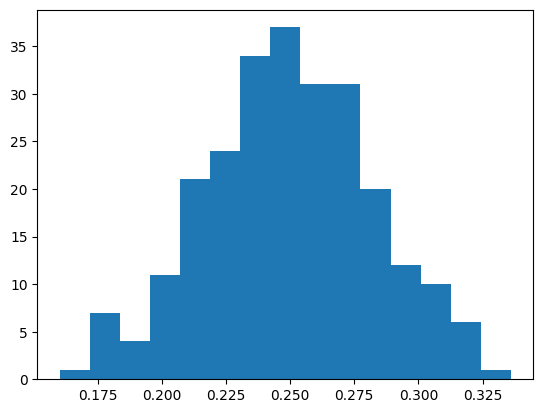

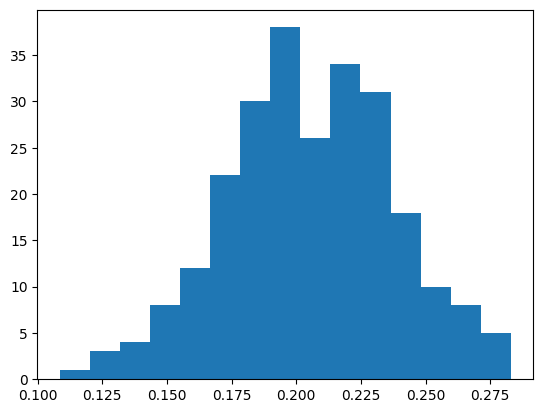

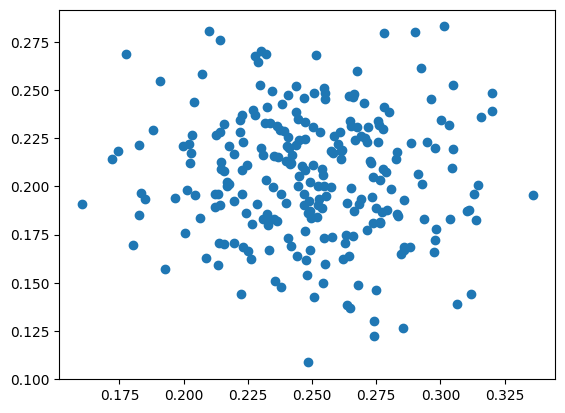

torch.Size([250, 13, 4])

In [31]:
# sample of weights from posterior for final layer
layer_sample = bnn_model.network[0].q_w().rsample((250,))  # shape [250, 4, 1]

w1 = layer_sample[:, 5, 0].detach()
w2 = layer_sample[:, 9, 0].detach()

plt.hist(w1, bins=15)
plt.show()
plt.hist(w2, bins=15)
plt.show()

plt.scatter(w1, w2)
plt.show()

layer_sample.shape

In [19]:
l,ll,kl = bnn_model.loss(x_train, y_train)

torch.Size([1])
tensor(239.3046, grad_fn=<AddBackward0>) torch.Size([])
